# Loading the libraries

In [1]:
# Unzip files
import zipfile

# Data exploration, statistics, visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Train and test split
from sklearn.model_selection import train_test_split

# Vectorization
from tensorflow.keras.preprocessing.text import Tokenizer

# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Embedding
from gensim.models import Word2Vec

# Word transformation
from transformers import DistilBertTokenizer 

# Algorithms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

from tensorflow.keras import layers, Sequential
from tensorflow.keras import callbacks

# Evaluation metrics
from sklearn.metrics import accuracy_score, f1_score

/Users/dorienroosen/.pyenv/versions/lewagon/envs/sap-one/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Data Loading

Load the fake and true news datasets from kaggle

In [3]:
# Requires Kaggle API token, present as ~/.kaggle/kaggle.json
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

100%|██████████████████████████████████████| 41.0M/41.0M [00:23<00:00, 1.68MB/s]
100%|██████████████████████████████████████| 41.0M/41.0M [00:23<00:00, 1.85MB/s]


In [4]:
zipfile.ZipFile('fake-and-real-news-dataset.zip').extractall()

In [5]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

Define the targets: 0 for Fake News, 1 for True news

In [6]:
fake_df['Target'] = 0 
true_df['Target'] = 1 


Merge both datasets into the combined news_df

In [7]:
news_df = pd.concat([fake_df,true_df]) 

# Data Exploration and preprocessing

In [8]:
news_df.head()

,title,text,subject,date,Target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
news_df.tail()

,title,text,subject,date,Target
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


## Check for missing values

In [10]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [11]:
news_df.isnull().sum()

title      0
text       0
subject    0
date       0
Target     0
dtype: int64

The dataset does not contain null values

For this analysis, I will exclude the date information and perform feature engineering on the text fields only. For further optimization of the models, I would include date information in the feature engineering process.

In [10]:
news_df.drop(columns = 'date', inplace = True)

## Target Balance

<AxesSubplot:xlabel='Target', ylabel='count'>

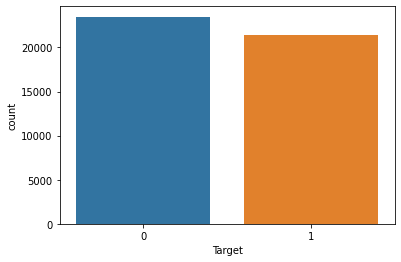

In [11]:
sns.countplot(x = news_df.Target)

The dataset is balanced, since there are similar amounts of true and fake news data.

## Subject distribution

[Text(0, 0, 'News'),
 Text(1, 0, 'politics'),
 Text(2, 0, 'Government News'),
 Text(3, 0, 'left-news'),
 Text(4, 0, 'US_News'),
 Text(5, 0, 'Middle-east'),
 Text(6, 0, 'politicsNews'),
 Text(7, 0, 'worldnews')]

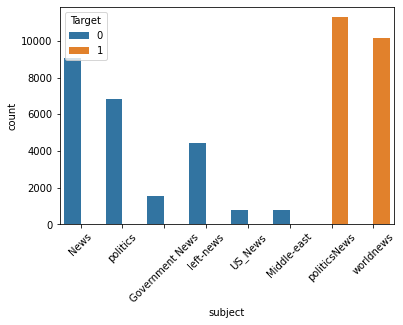

In [12]:
ax = sns.countplot(x = news_df.subject, hue = news_df.Target)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

Because the subjects are different for Fake news (0) and True news (1) entries in the dataframe, the subject column is excluded from the dataframe.

## Merge the text body and title

As both the title and the body of the text can contain valuable information to distinguish fake news from real news, I will concatenate the title and text columns into a single text column. 

In [13]:
news_df.text = news_df['text'] + " " + news_df['title']

In [14]:
news_df.drop(columns='title', inplace = True)

In [15]:
news_df

,text,subject,Target
0,Donald Trump just couldn t wish all Americans ...,News,0
1,House Intelligence Committee Chairman Devin Nu...,News,0
2,"On Friday, it was revealed that former Milwauk...",News,0
3,"On Christmas day, Donald Trump announced that ...",News,0
4,Pope Francis used his annual Christmas Day mes...,News,0
...,...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,1
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,1
21414,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,1
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,1


# Text cleaning/feature engineering

Visual inspection of the text entries of fake and real news shows that many true texts start with city/publisher information (e.g. 'WASHINGTON (Reuters) - '). To remove this from the body of the text, I will split off this information.

Even though the analysis of punctuation, numbers and capital letters can be valuable in NLP (e.g. the use of hashtags, all caps text, twitter handles might be more common in Fake news), I will remove it for this challenge. In further optimization rounds, I would analyze the impact of punctuation, capitalization and numbers as well.

I will also use a lemmatizer to stem all words to their roots.



## Remove publisher/city

In [16]:
def remove_publisher(text):
    text = text.split(" - ", maxsplit = 1)
    if len(text) == 2:
        return text[1]
    return text[0]

In [17]:
news_df['clean_text'] = news_df['text'].apply(remove_publisher)
news_df.tail()

,text,subject,Target,clean_text
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,1,NATO allies on Tuesday welcomed President Dona...
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,1,"LexisNexis, a provider of legal, regulatory an..."
21414,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,1,In the shadow of disused Soviet-era factories ...
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,1,Vatican Secretary of State Cardinal Pietro Par...
21416,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,1,Indonesia will buy 11 Sukhoi fighter jets wort...


## Remove punctuation

In [18]:
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [19]:
news_df['clean_text'] = news_df['clean_text'].apply(remove_punctuation)
news_df.tail()

,text,subject,Target,clean_text
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,1,NATO allies on Tuesday welcomed President Dona...
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,1,LexisNexis a provider of legal regulatory and ...
21414,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,1,In the shadow of disused Sovietera factories i...
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,1,Vatican Secretary of State Cardinal Pietro Par...
21416,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,1,Indonesia will buy 11 Sukhoi fighter jets wort...


## Remove numbers

In [20]:
def remove_numbers(text):
    text = ''.join(letter for letter in text if not letter.isdigit())
    return text

In [21]:
news_df['clean_text'] = news_df['clean_text'].apply(remove_numbers)
news_df.tail()

,text,subject,Target,clean_text
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,1,NATO allies on Tuesday welcomed President Dona...
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,1,LexisNexis a provider of legal regulatory and ...
21414,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,1,In the shadow of disused Sovietera factories i...
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,1,Vatican Secretary of State Cardinal Pietro Par...
21416,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,1,Indonesia will buy Sukhoi fighter jets worth ...


## Lower case

In [22]:
def lower_case(text):
    text = text.lower()
    return text

In [23]:
news_df['clean_text'] = news_df['clean_text'].apply(lower_case)
news_df.head()

,text,subject,Target,clean_text
0,Donald Trump just couldn t wish all Americans ...,News,0,donald trump just couldn t wish all americans ...
1,House Intelligence Committee Chairman Devin Nu...,News,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",News,0,on friday it was revealed that former milwauke...
3,"On Christmas day, Donald Trump announced that ...",News,0,on christmas day donald trump announced that h...
4,Pope Francis used his annual Christmas Day mes...,News,0,pope francis used his annual christmas day mes...


## Remove Stopwords 

In [24]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = [w for w in word_tokens if not w in stop_words]
    return text

In [25]:
news_df['clean_text'] = news_df['clean_text'].apply(remove_stopwords)
news_df.head()

,text,subject,Target,clean_text
0,Donald Trump just couldn t wish all Americans ...,News,0,"[donald, trump, wish, americans, happy, new, y..."
1,House Intelligence Committee Chairman Devin Nu...,News,0,"[house, intelligence, committee, chairman, dev..."
2,"On Friday, it was revealed that former Milwauk...",News,0,"[friday, revealed, former, milwaukee, sheriff,..."
3,"On Christmas day, Donald Trump announced that ...",News,0,"[christmas, day, donald, trump, announced, wou..."
4,Pope Francis used his annual Christmas Day mes...,News,0,"[pope, francis, used, annual, christmas, day, ..."


## Lemmatizing

In [26]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized

In [27]:
news_df['clean_text'] = news_df['clean_text'].apply(lemmatize)
news_df.tail()

,text,subject,Target,clean_text
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,1,"[nato, ally, tuesday, welcomed, president, don..."
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,1,"[lexisnexis, provider, legal, regulatory, busi..."
21414,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,1,"[shadow, disused, sovietera, factory, minsk, s..."
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,1,"[vatican, secretary, state, cardinal, pietro, ..."
21416,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,1,"[indonesia, buy, sukhoi, fighter, jet, worth, ..."


# Train/test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(news_df.clean_text, news_df.Target, random_state=0)

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33673,)
(33673,)
(11225,)
(11225,)


# NLP models

## RNN (LSTM) 

### Word2Vec Embedding

In [30]:
word2vec = Word2Vec(sentences = X_train)

In [31]:
def embed_sentence(word2vec, sentence):
    concat =  [word2vec.wv[word] for word in sentence if word in word2vec.wv ]
    return np.array(concat)

In [32]:
def embedding(word2vec, sentences):
    concat = [embed_sentence(word2vec, sentence) for sentence in sentences]
    return concat

Confirm that closely related words are also close in the word2vec embedding space:

In [33]:
word2vec.wv.most_similar('vote')

[('ballot', 0.6858223080635071),
 ('voted', 0.6797436475753784),
 ('voting', 0.6679921746253967),
 ('margin', 0.6165478229522705),
 ('win', 0.5822102427482605),
 ('overwhelmingly', 0.572297215461731),
 ('electoral', 0.5650050044059753),
 ('voter', 0.548642635345459),
 ('landslide', 0.5474008917808533),
 ('referendum', 0.5391635298728943)]

In [34]:
word2vec.wv.similar_by_vector(word2vec.wv['democratic'] - word2vec.wv['republican'] + word2vec.wv['trump'])

[('trump', 0.5257687568664551),
 ('democratic', 0.4611564576625824),
 ('obama', 0.41063418984413147),
 ('vladimir', 0.36367183923721313),
 ('clinton', 0.3518078029155731),
 ('incoming', 0.3456704318523407),
 ('presumptive', 0.33956947922706604),
 ('obamatrump', 0.3325781226158142),
 ('maduro', 0.3225840926170349),
 ('communist', 0.3190583288669586)]

word2vec embedding of the train and test data:

In [35]:
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

### Padding

Analyze the length of texts to determine padding size:

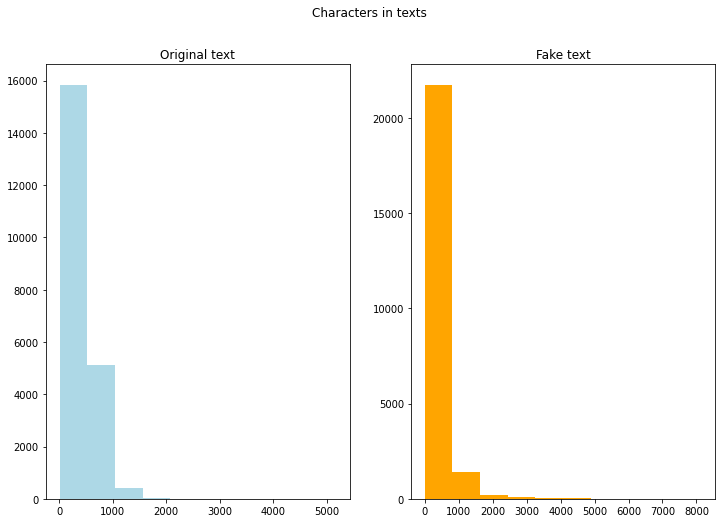

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len_true=news_df[news_df['Target']==1]['text'].str.split().map(lambda x: len(x))
text_len_fake=news_df[news_df['Target']==0]['text'].str.split().map(lambda x: len(x))

ax1.hist(text_len_true,color='lightblue',bins = 10)
ax1.set_title('Original text')

ax2.hist(text_len_fake,color='orange', bins = 10)
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')

plt.show()

As shown in the graph, majority of the text entries contain less that 500 words (both for True and Fake texts). Therefore I will limit the number of words to be embedded to 500, truncating texts with more than 500 words and padding text with less that 500 words.

In [37]:
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', value=0, maxlen=500)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', value=0, maxlen=500)

print(X_train_pad.shape)
print(X_test_pad.shape)

(33673, 500, 100)
(11225, 500, 100)


### Build the RNN model

For this exercise, I will use a 'simple' neural network with a single LSTM layer consisting of 15 neurons and a final Dense layer with sigmoid activation as it is a 2 category classification task. A masking layer is also included in order to ignore 0 values resulting from the padding.

In [38]:
from tensorflow.keras import layers, Sequential

rnn = Sequential([
    layers.Masking(mask_value=0),
    layers.LSTM(15),
    layers.Dense(1, activation="sigmoid")
])

rnn.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

2022-01-26 17:28:44.443855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the RNN model

To reduce computation time, I will use a batch_size of 256. In addition, I'll implement an early stopping criterion to prevent overfitting. To prevent data leakage, I'm including a validation set for the training of the model (30% split of the training data).

In [39]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=5, 
                             restore_best_weights=True)

history_rnn = rnn.fit(X_train_pad, y_train, 
                  epochs=200, 
                  batch_size=256, 
                  validation_split = 0.3, 
                  callbacks = es, 
                  verbose=1)

Epoch 1/200
93/93 [==============================] - 65s 566ms/step - loss: 0.3654 - accuracy: 0.8584 - val_loss: 0.1686 - val_accuracy: 0.9494
Epoch 2/200
93/93 [==============================] - 42s 445ms/step - loss: 0.1218 - accuracy: 0.9622 - val_loss: 0.0867 - val_accuracy: 0.9738
Epoch 3/200
93/93 [==============================] - 40s 428ms/step - loss: 0.0742 - accuracy: 0.9778 - val_loss: 0.0623 - val_accuracy: 0.9800
Epoch 4/200
93/93 [==============================] - 40s 431ms/step - loss: 0.0540 - accuracy: 0.9841 - val_loss: 0.0527 - val_accuracy: 0.9835
Epoch 5/200
93/93 [==============================] - 45s 488ms/step - loss: 0.0434 - accuracy: 0.9871 - val_loss: 0.0455 - val_accuracy: 0.9859
Epoch 6/200
93/93 [==============================] - 43s 466ms/step - loss: 0.0344 - accuracy: 0.9902 - val_loss: 0.0483 - val_accuracy: 0.9853
Epoch 7/200
93/93 [==============================] - 45s 482ms/step - loss: 0.0283 - accuracy: 0.9917 - val_loss: 0.0439 - val_accuracy:

In [40]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 500, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 15)                6960      
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 6,976
Trainable params: 6,976
Non-trainable params: 0
_________________________________________________________________


### Evaluate the RNN model

Evaluation of the loss and accuracy of the train and validation data across epochs:

In [41]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validate'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validate'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

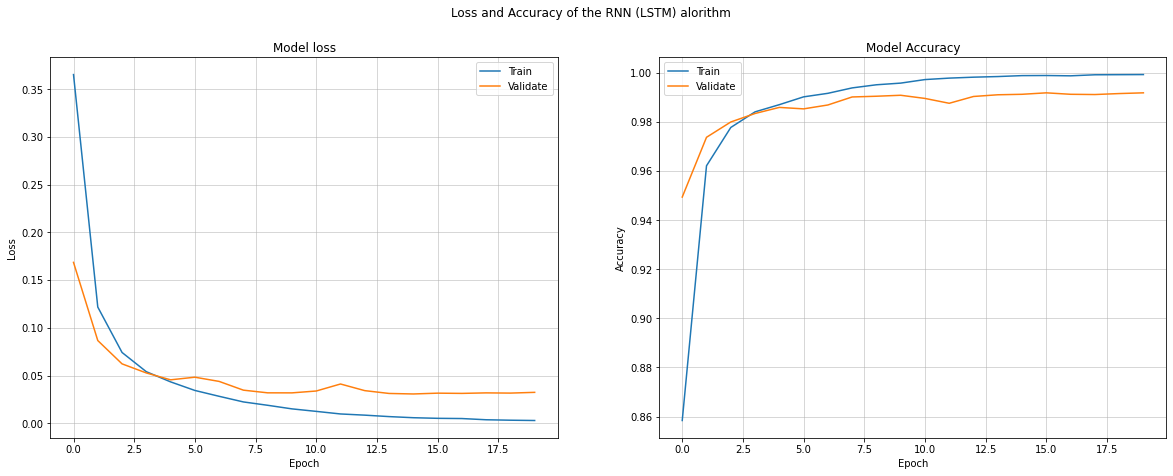

In [42]:
plot_loss_accuracy(history_rnn, title='Loss and Accuracy of the RNN (LSTM) alorithm')

Analysis of the loss and accuracy curves over the epochs confirm that both metrics for training and validation data converge over time and that the algorithm is not overfitting.

Calculate the F1-score and Accuracy of the testing data:

In [43]:
y_pred_rnn = (rnn.predict(X_test_pad) >= 0.5).astype("int")

acc_rnn = accuracy_score(y_test, y_pred_rnn)
print(f'The Accuracy of RNN is {round(acc_rnn*100,2)}%')
f1_rnn = f1_score(y_test, y_pred_rnn)
print(f'The F1-score of RNN is {round(f1_rnn*100,2)}%')

The Accuracy of RNN is 99.0%
The F1-score of RNN is 98.96%


## CNN 

### Build the CNN model

For the CNN model, the same embedded + padded X_train data will be used as for the RNN model above.

I will use a 'simple' neural network with a single Conv1D layer consisting of 15 neurons, a subsequent flattening layer and a final Dense layer with sigmoid activation as it is a 2 category classification task. A masking layer is also included in order to ignore 0 values resulting from the padding.

In [44]:
cnn = Sequential([
    layers.Masking(mask_value=0),
    layers.Conv1D(15, kernel_size = 3),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train the CNN model

To reduce computation time, I will use a batch_size of 256. In addition, I'll implement an early stopping criterion to prevent overfitting. To prevent data leakage, I'm including a validation set for the training of the model (30% split of the training data).

In [45]:
es = callbacks.EarlyStopping(patience=5, 
                             restore_best_weights=True)

history_cnn = cnn.fit(X_train_pad, y_train, 
                      epochs=200, 
                      batch_size=256, 
                      validation_split = 0.3,
                      callbacks = es, 
                      verbose=1)

Epoch 1/200
93/93 [==============================] - 29s 281ms/step - loss: 0.1740 - accuracy: 0.9324 - val_loss: 0.0742 - val_accuracy: 0.9750
Epoch 2/200
93/93 [==============================] - 23s 249ms/step - loss: 0.0513 - accuracy: 0.9833 - val_loss: 0.0716 - val_accuracy: 0.9755
Epoch 3/200
93/93 [==============================] - 23s 243ms/step - loss: 0.0330 - accuracy: 0.9910 - val_loss: 0.0624 - val_accuracy: 0.9786
Epoch 4/200
93/93 [==============================] - 20s 216ms/step - loss: 0.0247 - accuracy: 0.9929 - val_loss: 0.0564 - val_accuracy: 0.9826
Epoch 5/200
93/93 [==============================] - 21s 225ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.0592 - val_accuracy: 0.9812
Epoch 6/200
93/93 [==============================] - 19s 202ms/step - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.0616 - val_accuracy: 0.9811
Epoch 7/200
93/93 [==============================] - 21s 221ms/step - loss: 0.0112 - accuracy: 0.9974 - val_loss: 0.0610 - val_accuracy:

In [46]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 500, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 498, 15)           4515      
                                                                 
 flatten (Flatten)           (None, 7470)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7471      
                                                                 
Total params: 11,986
Trainable params: 11,986
Non-trainable params: 0
_________________________________________________________________


### Evaluate the CNN model

Evaluation of the loss and accuracy of the train and validation data across epochs:

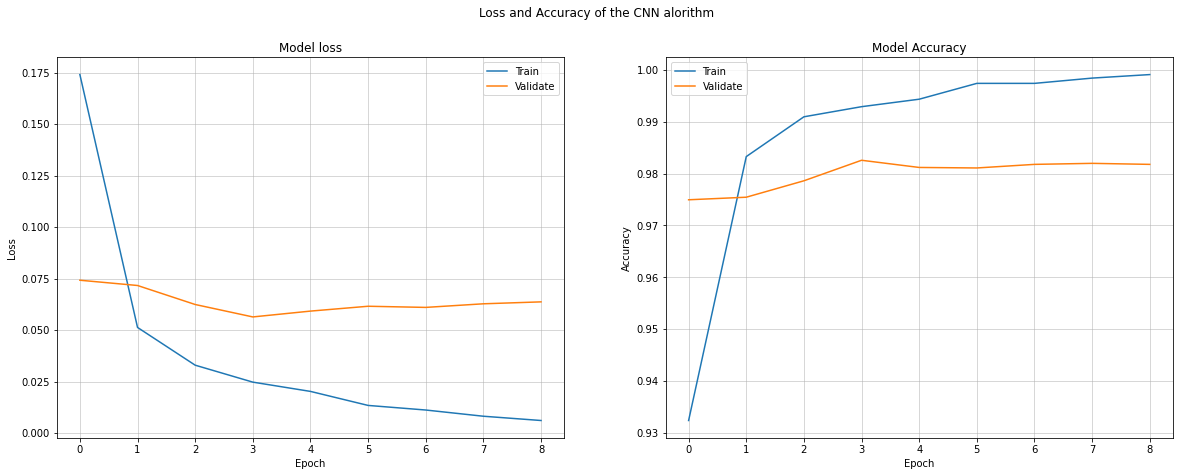

In [47]:
plot_loss_accuracy(history_cnn, title='Loss and Accuracy of the CNN alorithm')

Analysis of the loss and accuracy curves over the epochs confirm that both metrics for training and validation data converge over time and that the algorithm is not overfitting.

Calculate the F1-score and Accuracy of the testing data:

In [48]:
y_pred_cnn = (cnn.predict(X_test_pad) >= 0.5).astype("int")

acc_cnn = accuracy_score(y_test, y_pred_cnn)
print(f'The Accuracy of CNN is {round(acc_cnn*100,2)}%')
f1_cnn = f1_score(y_test, y_pred_cnn)
print(f'The F1-score of CNN is {round(f1_cnn*100,2)}%')

The Accuracy of CNN is 98.0%
The F1-score of CNN is 97.91%


## XGBoost

### Transformation with DistilBERT

Here, words are transformed using a pre-trained word transformer DisitlBERT. As shown in the graph above, the majority of the text entries contain less that 500 words (both for True and Fake texts). Therefore I will limit tokenization to 500, truncating texts with more than 500 words and padding text with less that 500 words.

In [49]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [50]:
X_train_dbert = tokenizer(X_train.to_list(), is_split_into_words = True, max_length = 500, padding = True, truncation = True)['input_ids']
X_test_dbert = tokenizer(X_test.to_list(), is_split_into_words = True, max_length = 500, padding = True, truncation = True)['input_ids']

### Train the model

In [51]:
xgb = XGBClassifier(use_label_encoder=False, missing = 0)

In [52]:
xgb.fit(X_train_dbert, y_train)

[18:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Evaluate the model

Calculate the F1-score and Accuracy of the testing data:

In [53]:
y_pred_xgb = xgb.predict(X_test_dbert)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"The accuracy of XGBOOST is: {round(acc_xgb*100, 2)}%")

f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"The F1-score of XGBOOST is: {round(f1_xgb*100, 2)}%")

The accuracy of XGBOOST is: 87.63%
The F1-score of XGBOOST is: 86.18%


# Summary, Conclusion and Future Analysis

## Summary

### Models

For Natural Language Processing (NLP), deep learning algorithms are typically applied because they efficiently capture complex and non-linear relationships in text data. For this NLP Classification challenge, I trained two deep learning models, one with a Recurrent Neural Network architecture (RNN) and another with a Convolutional Neural Network (CNN) architecture. In addition, I trained the advanced gradient boosting machine learning algorithm XGBoost.

#### RNN

RNN is a neuronal network architecture for sequential data such as texts, with each sentence being a sequence of words. RNN is especially powerful for the analysis of longer texts where feature detection is important. Here, I chose to use a Long Short-Term Memory (LSTM) architecture to overcome vanishing gradient problems. 

#### CNN

CNN is another DL architecture that can be employed for the classification of hierarchical data. Even though CNN is typically used in image processing applications, they can also be effectively be used on text data. Here, sequences are representes as a matrix and a one-dimensional convolution can be used to 'slide' along the text-axis with a kernel-size of choice. A major advantage of CNN compared to RNN is that it significantly reduces computational complexity while preserving important features, and it works particularly well on shorter texts.

#### XGBoost

In addition to the deep learning models, I also trained the gradient boosting algorithm XGBoost. It implements parallel tree boosting and is able to solve complex data science problems fast and accurately. Other ML models for the detection of fake news could have included the Naive Bayes Algorithm or Random Forest Regressor, or other more advanced ML models such as LightGBM or CatBoost.

### Vectorizing and embedding

For both the RNN and CNN model training, I used the word embedder Word2Vec (other embedder options could have been GloVe or FastText), as it is both robust and computationally fast. During Word2Vec embedding, words are mapped to a multi-dimensional vector in such a way that words with similar context are close to each other in this mathematical space, which was verified by word arithmetics. 

However, Word Embedding transforms the input data into a 3-dimensional vector, and the XGBoost algorithm requires a 2D input. Rather than using standard vectorization (e.g. using Bag of Words, Tf-ldf), I used a pre-trained word transformer. Compared to standard vectorizing techniques, word transformation manages to capture context and has the additional advantage that it can assign different vectors to the same word based on its meaning. Here, I used the pre-trained 'Distil-BERT', a distilled, lighter version of 'BERT', that preserves 95% of the BERT performance while reducing the number of parameters by half. 

## Conclusion

Visual comparison of the performance metrics on the test data:

[Text(0.5, 1.0, 'Performance scores test data (%)')]

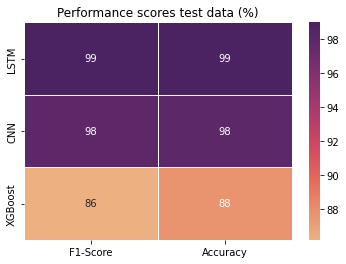

In [54]:
scores = np.array([
    [f1_rnn*100, acc_rnn*100], 
    [f1_cnn*100, acc_cnn*100], 
    [f1_xgb*100, acc_xgb*100]
])
 
sns.heatmap(scores, 
            linewidth = 1 , 
            annot = True, 
            xticklabels=['F1-Score', 'Accuracy'], 
            yticklabels=['LSTM', 'CNN', 'XGBoost'], 
            cmap = 'flare').set(title="Performance scores test data (%)")


Based on this analysis, both deep learning models outperform the XGBoost algorithm. Of those, I prefer the CNN algorithm. Even though the performance scores of the CNN and RNN/LSTM model are very similar, the CNN model required significantly less computational time.

## Future analysis

Further optimization steps could include:

- Optimize the number of neurons and number of layers in the deep learning models.
- Train different models. Other examples of algorithms suited for text classification include the Naive Bayes Algorithm, RandomForestRegressor and LightGBM.
- Apply different vectorizers (e.g. Bag of Words, N-Grams), word embedders (e.g. GloVe, FastText) or word transformers (e.g. BERT, RoBERTa).
- Fine-tune the hyper-parameters of the algorithms, word embedders and word transformers and using GridSearch.
- Further fine-tune data preprocessing and feature engineering steps e.g. presence twitter handles and urls, vocabulary richness, date information, digit/character ratio, capitalization.
